# Feature Selection
----

<h4> Description </h4>
In this notebook I look for the best set of features. I also trying re-scaling the colors by subtraction the red-sequence mean color.

In [1]:
import numpy as np
import astropy.io.ascii as at
import scipy.stats as st
from astropy.table import Table, vstack, join
from astropy.io.fits import getdata

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import os

sns.set_style("whitegrid")
sns.set_context('talk',rc={"lines.linewidth": 2.5})

## Load Cosmos Sample

In [2]:
# path = '/data/des61.a/data/johnny/COSMOS/fnal2022/'
# fname = path+'desCosmosML_sample.fits'
# joined = Table(getdata(fname))

In [3]:
### get machine learning selection

In [4]:
def transform_to_1d(x,y):
    ynew = y[:,0]
    xnew = np.vstack([y[:,2],x.T,y[:,1]]).T
    return xnew, ynew

In [5]:
path = '../data/'
x_train = np.load(path+'qf_x_train.npy')
y_train = np.load(path+'qf_y_train.npy')

x_test = np.load(path+'qf_x_test.npy')
y_test = np.load(path+'qf_y_test.npy')

# y_train_err = np.array(joined['smass_err'][joined['Train']])

In [6]:
x_test1d, y_test1d = transform_to_1d(x_test,y_test)
x_train1d, y_train1d = transform_to_1d(x_train,y_train)

In [7]:
x_train_small = x_train1d[:,4:]
x_test_small = x_test1d[:,4:]

## Cross Validation Sample

In [8]:
import sys

sys.path.append('/data/des81.a/data/jesteves/GitHub/galpro')
from galpro.convert_mag_to_lupmag import get_input_galpro, convert_mag_to_lupmag

# def convert_mag_to_fluxes(mag,f_o=10**12):
#     return f_o*10.**(-mag/2.5)

# def convert_mag_to_lupmag(mags, a=2.5*np.log10(np.exp(1)), f_o=10**12):
#     # define quantities
#     m_o = 2.5*np.log10(f_o)
#     #mags = np.c_[g,r,i,z]
#     fluxes = convert_mag_to_fluxes(mags)

#     # sigma = 10**np.std(np.log10(fluxes),axis=0)
#     sigma = np.array([28.79631884352346, 39.89162179800252, 67.37310780328083, 118.70759986796102]) # g,r,i,z
#     b = np.sqrt(a)*sigma

#     # define g,r,i,z fluxes as a numpy array
#     # luptitudes and errors
#     lups = (m_o - 2.5*np.log10(b)) - a*np.arcsinh(fluxes/(2*b))
#     lup_errors = np.sqrt(((a**2) * (sigma**2)) / (4*(b**2) + (fluxes**2)))

#     return lups, lup_errors

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [9]:
from astropy.cosmology import WMAP9 as cosmo
## load target data
fname = '../data/des_sdssGalexWISE_matched.csv'
data = at.read(fname)

mags = np.c_[[data['sof_cm_mag_corrected_%s'%bp_filter] for bp_filter in ['g','r','i','z']]].T
mags_err = np.c_[[data['sof_cm_mag_err_%s'%bp_filter] for bp_filter in ['g','r','i','z']]].T
mask= data['sdss_mass']>0.
ztrue= data['sdss_z']

x_target = get_input_galpro(mags[mask],ztrue[mask])
distMod = cosmo.distmod(ztrue[mask]).value
absMags = x_target[:,:4]-distMod[:,np.newaxis]

ssfr = np.log10(10**np.array(data['sdss_sfr'])/10**np.array(data['sdss_mass']))
qf = np.where(ssfr<-11.5, 1, 0)

x_target1d = np.c_[qf[mask],x_target,absMags[:,2]]

y_target = np.array(data['sdss_mass'][mask])
x_target_small = x_target1d[:,4:]

Text(0.5,1,'Red and Blue')

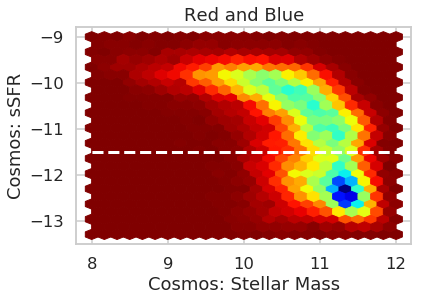

In [10]:
plt.hexbin(y_target,ssfr[mask],extent=[8,12,-13.3,-9],gridsize=24,cmap='jet_r')
plt.axhline(-11.5,color='w',ls='--',lw=3)
plt.xlabel('Cosmos: Stellar Mass')
plt.ylabel('Cosmos: sSFR')
plt.title('Red and Blue')

In [11]:
# x_train_small = x_train1d[:,4:].copy()
# for ix in range(3):
#     x_train_small[:,ix] -= np.interp(x_train_small[:,-2],rsMean[0],rsMean[ix])

(0.0, 1.0)

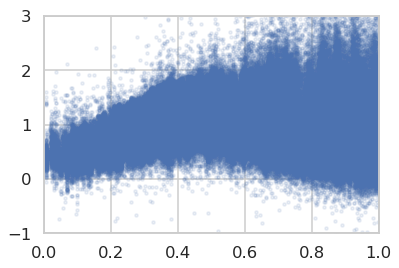

In [12]:
for ix in [1]:#range(3):
    #plt.hist(x_train_small[:,ix],bins=np.linspace(-2,1,31))
    plt.scatter(x_train_small[:,-2],x_train_small[:,ix],s=10,alpha=0.1)
    
plt.ylim(-1,3)
plt.xlim(0.,1.)

## Training with ML Architectures - Quenching Label

In [13]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
import time

# from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import make_pipeline

n_estimators = 10
n_cores = -1
# ann_params = {'hidden_layer_sizes':(50,100),'alpha': 0.7207482891524928, 'learning_rate_init': 0.0101}
ann_pipeline = make_pipeline(MLPRegressor())
rf_pipeline = make_pipeline(RandomForestRegressor(n_jobs=n_cores))
gradient_pipeline = make_pipeline(GradientBoostingRegressor())
svm_pipeline = make_pipeline(BaggingRegressor(SVR(), max_samples=1.0 / n_estimators,
                             n_estimators=n_estimators,n_jobs=n_cores))

estimators = [('ANN', ann_pipeline),
              ('Random Forest', rf_pipeline),
              ('Gradient Boosting', gradient_pipeline),
              ('SVM', svm_pipeline)]

In [14]:
# idx = np.random.randint(len(y_train1d), size=10000)
idx = np.arange(len(y_train1d))
x = x_train_small[idx,:]
y = y_train1d[idx]

In [15]:
def header(name):
    print(5*'-----')
    print('Machine Learning Training: %s'%name)

def fit(self,x,y):
    start_time = time.time()
    self.fit(x,y)
    self.elapsed_time = (time.time()-start_time)/60.
    print('Elapsed time: %.2f min'%self.elapsed_time)
    
for (name, estimator) in estimators:
    header(name)
    fit(estimator,x,y)
    print('')

-------------------------
Machine Learning Training: ANN
Elapsed time: 0.06 min

-------------------------
Machine Learning Training: Random Forest
Elapsed time: 0.08 min

-------------------------
Machine Learning Training: Gradient Boosting
Elapsed time: 0.58 min

-------------------------
Machine Learning Training: SVM
Elapsed time: 0.70 min



In [16]:
def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=3)
    ax.scatter(y_true, y_pred, alpha=0.9,s=20)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left',fontsize=16)
    title = title + '\n Evaluation in {:.2f} seconds'.format(elapsed_time)
    ax.set_title(title)
    
def median_abs_deviation(x,scale=1.0):
    return np.median(np.abs(x-np.median(x)))/scale

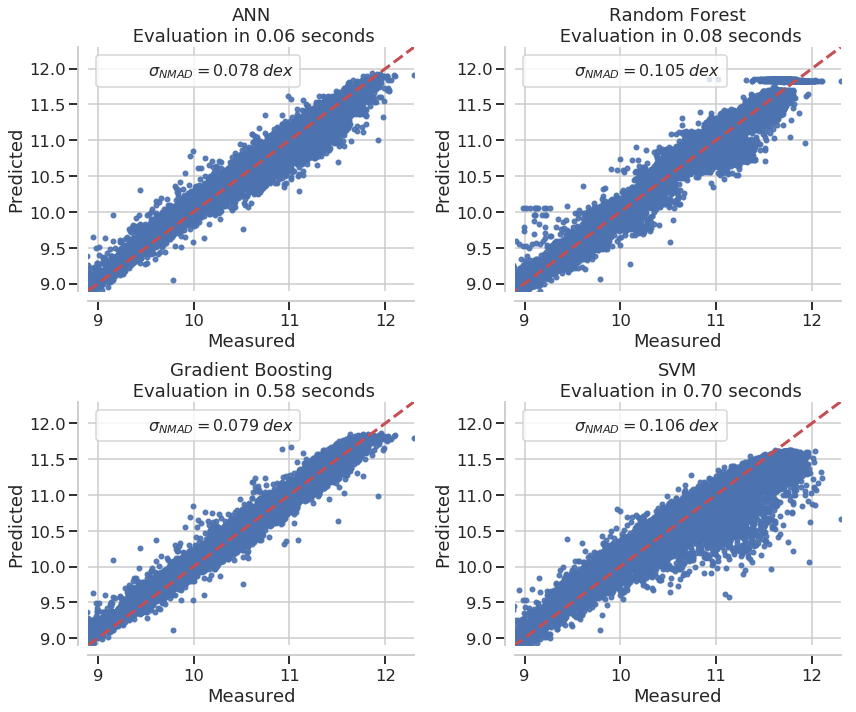

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = np.ravel(axs)

for ax, (name, est) in zip(axs, estimators):
    elapsed_time = est.elapsed_time
    y_target_pred = est.predict(x_target_small)
    snmad = median_abs_deviation(y_target-y_target_pred,scale=1/1.4826)
    offset = np.median(y_target-y_target_pred)
    plot_regression_results(
        ax, y_target, y_target_pred+offset,
        name, r'$\sigma_{NMAD} = %.3f \; dex$'%(snmad),
        elapsed_time)
    ax.set_xlim(8.9,)
    ax.set_ylim(8.9,)
# plt.suptitle('Single predictors versus stacked predictors')
plt.tight_layout()
# plt.subplots_adjust(top=0.9)
fig.savefig('compare_different_ml_predictors.png',dpi=100,facecolor='w',transparent=False)

# Feature Selection

In [18]:
import time
import numpy as np

est = estimators[2][1].steps[0][1]
start_time = time.time()
importances = est.feature_importances_
std = np.std([est.feature_importances_ for tree in est.estimators_], axis=0)
elapsed_time = time.time() - start_time

print("Elapsed time to compute the importances: {elapsed_time:.3f} seconds".format(elapsed_time=elapsed_time))

Elapsed time to compute the importances: 0.144 seconds


In [19]:
feature_names = [r'Red']
feature_names+= [r'$(%s - %s)$'%(bp0,bp1) for bp0, bp1 in zip(['g','r','i'],['r','i','z'])]
feature_names+= ['Mag_err_%s'%bpF for bpF in ['g','r','i','z']]
feature_names+= ['Err(%s - %s)'%(bp0,bp1) for bp0, bp1 in zip(['g','r','i'],['r','i','z'])]
feature_names+= ['redshift']
feature_names+= [r'$M_z$']

feature_names

['Red',
 '$(g - r)$',
 '$(r - i)$',
 '$(i - z)$',
 'Mag_err_g',
 'Mag_err_r',
 'Mag_err_i',
 'Mag_err_z',
 'Err(g - r)',
 'Err(r - i)',
 'Err(i - z)',
 'redshift',
 '$M_z$']

In [20]:
len(feature_names)

13

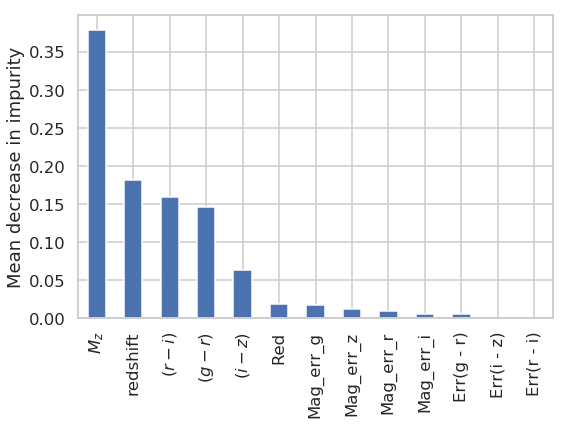

In [21]:
import pandas as pd

ix = np.argsort(-1*importances)
forest_importances = pd.Series(importances[ix], index=np.array(feature_names)[ix])

fig, ax = plt.subplots(figsize=(8,6))
forest_importances.plot.bar(yerr=std[ix], ax=ax)
# ax.set_title("Cosmos with Mag-DM and RedSeq Offset")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
# fig.savefig('feature_importance_mag_dm_rs.png',dpi=100,transparent=False,facecolor='w')

In [22]:
# # xhigh = y_target>11.6
# for name, est in estimators:
#     ypred = est.predict(x_target_small)
#     res = ypred-y_target
#     yhigh = (ypred-np.median(res))>11.6
#     plt.hist((res-np.median(res))[yhigh], bins=np.linspace(-0.3,0.3,31),histtype='step',label=name)
#     plt.title('High Mass Galaxies: $M_{\star}>11.6$')
# plt.xlabel('Log($M_{\star,DES}/M_{\star,SDSS}$)')
# plt.legend(fontsize=12,loc=2)

## Model 3 Colors + 1Mag + 1Abs Mag + 1 Mag Err

Only z-band

In [42]:
colors = x_train[:,4:(4+3)]
Mz = x_train1d[:,-1]
mz = x_train[:,3]
mz_err = x_train[:,4+3+3]
z = x_train1d[:,-2]
x_train_0 = np.c_[Mz,colors[:,:3],mz,mz_err,z]

In [43]:
x_target_0 = np.c_[x_target1d[:,-1],x_target[:,4:(4+3)],x_target[:,3],x_target[:,4+3+3],x_target1d[:,-2]]

In [44]:
# idx = np.random.randint(len(y_train1d), size=10000)
idx = np.arange(len(y_train1d))
x = x_train_0[idx]
y = y_train1d[idx]

In [45]:
for (name, estimator) in estimators:
    header(name)
    fit(estimator,x,y)
    print('')

-------------------------
Machine Learning Training: ANN
Elapsed time: 0.16 min

-------------------------
Machine Learning Training: Random Forest
Elapsed time: 0.05 min

-------------------------
Machine Learning Training: Gradient Boosting
Elapsed time: 0.29 min

-------------------------
Machine Learning Training: SVM
Elapsed time: 0.51 min



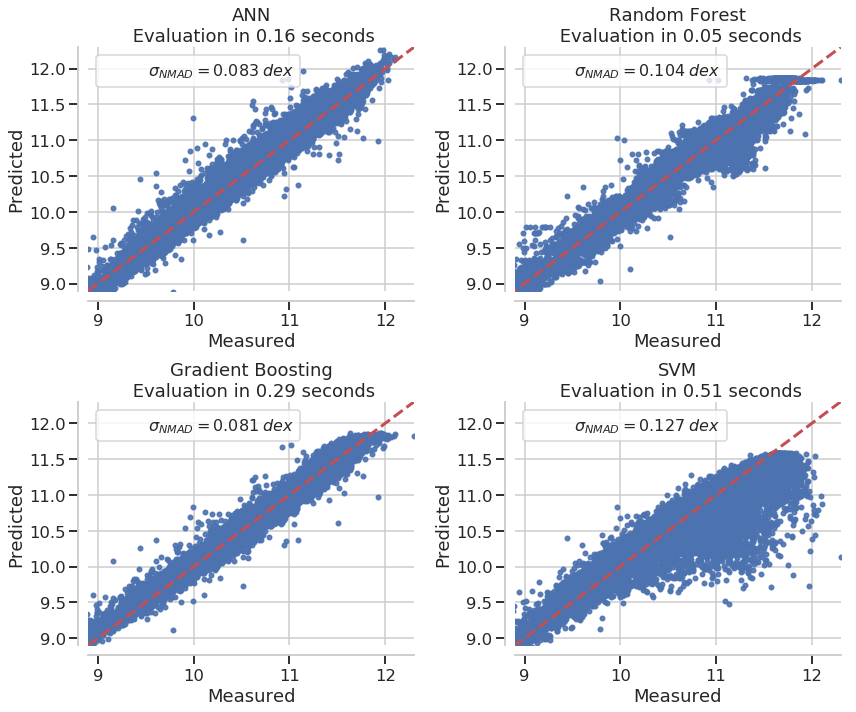

In [46]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = np.ravel(axs)

for ax, (name, est) in zip(axs, estimators):
    elapsed_time = est.elapsed_time
    y_target_pred = est.predict(x_target_0)
    snmad = median_abs_deviation(y_target-y_target_pred,scale=1/1.4826)
    offset = np.median(y_target-y_target_pred)
    plot_regression_results(
        ax, y_target, y_target_pred+offset,
        name, r'$\sigma_{NMAD} = %.3f \; dex$'%(snmad),
        elapsed_time)
    ax.set_xlim(8.9,)
    ax.set_ylim(8.9,)
# plt.suptitle('Single predictors versus stacked predictors')
plt.tight_layout()
# plt.subplots_adjust(top=0.9)
fig.savefig('compare_different_ml_predictors.png',dpi=100,facecolor='w',transparent=False)

Elapsed time to compute the importances: 0.177 seconds


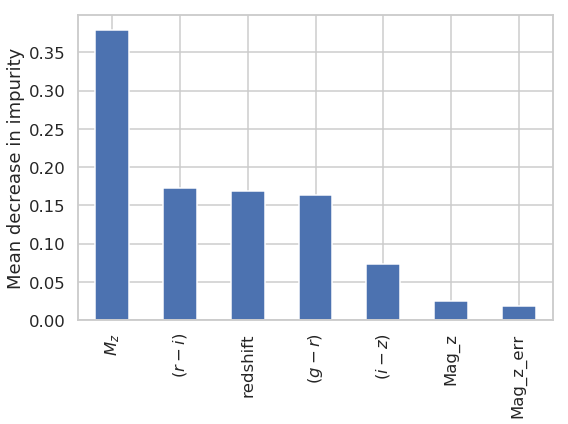

In [47]:
est = estimators[2][1].steps[0][1]
start_time = time.time()
importances = est.feature_importances_
std = np.std([est.feature_importances_ for tree in est.estimators_], axis=0)
elapsed_time = time.time() - start_time

print("Elapsed time to compute the importances: {elapsed_time:.3f} seconds".format(elapsed_time=elapsed_time))

feature_names = [r'$M_z$']
feature_names+= [r'$(%s - %s)$'%(bp0,bp1) for bp0, bp1 in zip(['g','r','i'],['r','i','z'])]
feature_names+= ['Mag_%s'%bpF for bpF in ['z']]
feature_names+= ['Mag_%s_err'%bpF for bpF in ['z']]
# feature_names+= ['Err(%s - %s)'%(bp0,bp1) for bp0, bp1 in zip(['g','r','i'],['r','i','z'])]
feature_names+= ['redshift']


feature_names

ix = np.argsort(-1*importances)
forest_importances = pd.Series(importances[ix], index=np.array(feature_names)[ix])

fig, ax = plt.subplots(figsize=(8,6))
forest_importances.plot.bar(yerr=std[ix], ax=ax)
# ax.set_title("Cosmos with Mag-DM and RedSeq Offset")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
# fig.savefig('feature_importance_mag_dm_rs.png',dpi=100,transparent=False,facecolor='w')

## Model 3 RS Offset + 1Mag + 1Abs Mag + 1 Mag Err

Only z-band

In [30]:
rsMean = np.load('../data/redSequence_deepField_mean_color.npy')
colors_rs = colors.copy()
colors_target_rs = x_target[:,4:(4+3)].copy()
for ix in range(3):
    colors_rs[:,ix] -= np.interp(x_train_small[:,-2],rsMean[0],rsMean[ix])
    colors_target_rs[:,ix] -= np.interp(x_target_small[:,-2],rsMean[0],rsMean[ix])

In [31]:
# rsMean

In [32]:
# for i in [0]:#range(3):
#     plt.scatter(rsMean[0],rsMean[i],s=10,alpha=0.1)
#     plt.scatter(x_train1d[:,-2],colors_rs[:,i],s=10,alpha=0.1)
#     plt.ylim(-2,2)

In [33]:
Mz = x_train1d[:,-1]
mz = x_train[:,3]
mz_err = x_train[:,4+3+3]
z = x_train1d[:,-2]
x_train_1 = np.c_[Mz,colors_rs,mz,mz_err,z]

In [34]:
x_target_1 = np.c_[x_target1d[:,-1],colors_target_rs,x_target[:,3],x_target[:,4+3+3],x_target1d[:,-2]]

In [35]:
# idx = np.random.randint(len(y_train1d), size=10000)
idx = np.arange(len(y_train1d))
x = x_train_1[idx]
y = y_train1d[idx]

In [36]:
for (name, estimator) in estimators:
    header(name)
    fit(estimator,x,y)
    print('')

-------------------------
Machine Learning Training: ANN
Elapsed time: 0.18 min

-------------------------
Machine Learning Training: Random Forest
Elapsed time: 0.04 min

-------------------------
Machine Learning Training: Gradient Boosting
Elapsed time: 0.29 min

-------------------------
Machine Learning Training: SVM
Elapsed time: 0.54 min



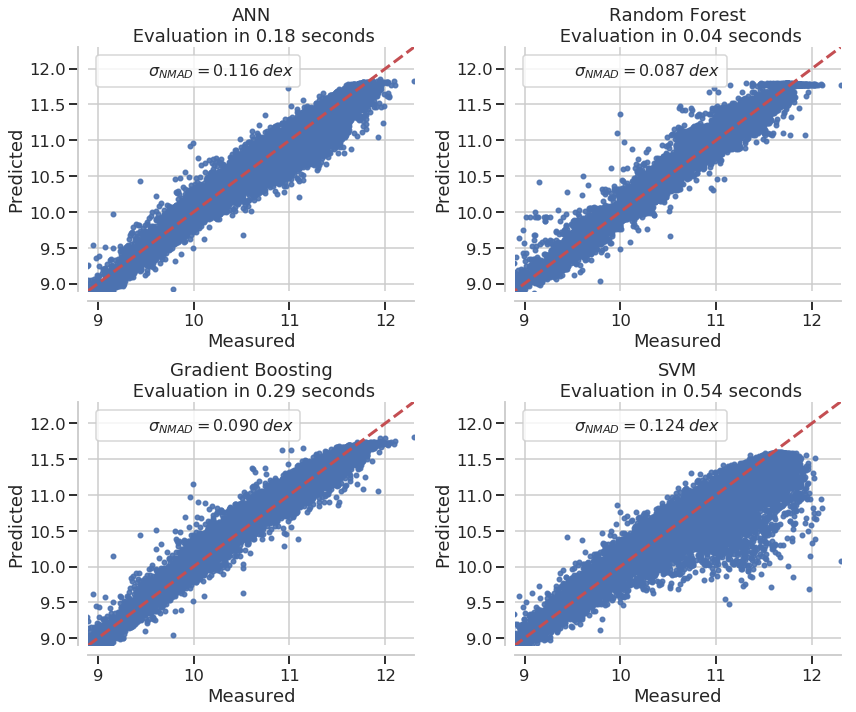

In [37]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = np.ravel(axs)

for ax, (name, est) in zip(axs, estimators):
    elapsed_time = est.elapsed_time
    y_target_pred = est.predict(x_target_1)
    snmad = median_abs_deviation(y_target-y_target_pred,scale=1/1.4826)
    offset = np.median(y_target-y_target_pred)
    plot_regression_results(
        ax, y_target, y_target_pred+offset,
        name, r'$\sigma_{NMAD} = %.3f \; dex$'%(snmad),
        elapsed_time)
    ax.set_xlim(8.9,)
    ax.set_ylim(8.9,)
# plt.suptitle('Single predictors versus stacked predictors')
plt.tight_layout()
# plt.subplots_adjust(top=0.9)
fig.savefig('compare_different_ml_predictors.png',dpi=100,facecolor='w',transparent=False)

Elapsed time to compute the importances: 0.137 seconds


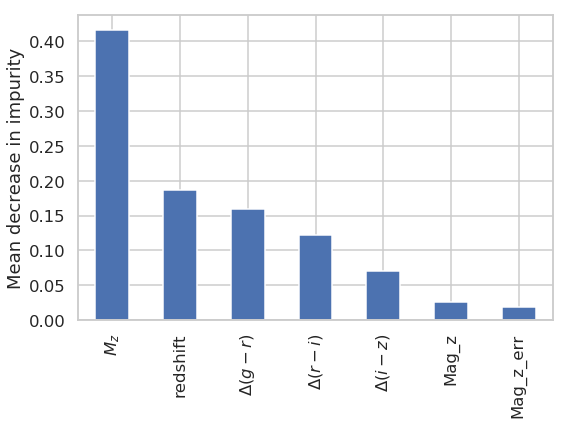

In [41]:
est = estimators[2][1].steps[0][1]
start_time = time.time()
importances = est.feature_importances_
std = np.std([est.feature_importances_ for tree in est.estimators_], axis=0)
elapsed_time = time.time() - start_time

print("Elapsed time to compute the importances: {elapsed_time:.3f} seconds".format(elapsed_time=elapsed_time))

feature_names = [r'$M_z$']
feature_names+= [r'$\Delta (%s - %s)$'%(bp0,bp1) for bp0, bp1 in zip(['g','r','i'],['r','i','z'])]
feature_names+= ['Mag_%s'%bpF for bpF in ['z']]
feature_names+= ['Mag_%s_err'%bpF for bpF in ['z']]
# feature_names+= ['Err(%s - %s)'%(bp0,bp1) for bp0, bp1 in zip(['g','r','i'],['r','i','z'])]
feature_names+= ['redshift']


feature_names

ix = np.argsort(-1*importances)
forest_importances = pd.Series(importances[ix], index=np.array(feature_names)[ix])

fig, ax = plt.subplots(figsize=(8,6))
forest_importances.plot.bar(yerr=std[ix], ax=ax)
# ax.set_title("Cosmos with Mag-DM and RedSeq Offset")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
# fig.savefig('feature_importance_mag_dm_rs.png',dpi=100,transparent=False,facecolor='w')

# Abs Mag + 3 Colors + Redshift

In [48]:
# rsMean = np.load('../data/redSequence_deepField_mean_color.npy')
# colors_rs = colors.copy()
# colors_target_rs = x_target[:,4:(4+3)].copy()
# for ix in range(3):
#     colors_rs[:,ix] -= np.interp(x_train_small[:,-2],rsMean[0],rsMean[ix])
#     colors_target_rs[:,ix] -= np.interp(x_target_small[:,-2],rsMean[0],rsMean[ix])

In [31]:
# rsMean

In [32]:
# for i in [0]:#range(3):
#     plt.scatter(rsMean[0],rsMean[i],s=10,alpha=0.1)
#     plt.scatter(x_train1d[:,-2],colors_rs[:,i],s=10,alpha=0.1)
#     plt.ylim(-2,2)

In [57]:
Mz = x_train1d[:,-1]
mz = x_train[:,3]
mz_err = x_train[:,4+3+3]
z = x_train1d[:,-2]
x_train_2 = np.c_[Mz, colors, mz_err, z]

In [58]:
x_target_2 = np.c_[x_target1d[:,-1], x_target[:,4:(4+3)], x_target[:,4+3+3],x_target1d[:,-2]]

In [60]:
# idx = np.random.randint(len(y_train1d), size=10000)
idx = np.arange(len(y_train1d))
x = x_train_2[idx]
y = y_train1d[idx]

In [61]:
for (name, estimator) in estimators:
    header(name)
    fit(estimator,x,y)
    print('')

-------------------------
Machine Learning Training: ANN
Elapsed time: 0.05 min

-------------------------
Machine Learning Training: Random Forest
Elapsed time: 0.04 min

-------------------------
Machine Learning Training: Gradient Boosting
Elapsed time: 0.25 min

-------------------------
Machine Learning Training: SVM
Elapsed time: 0.47 min



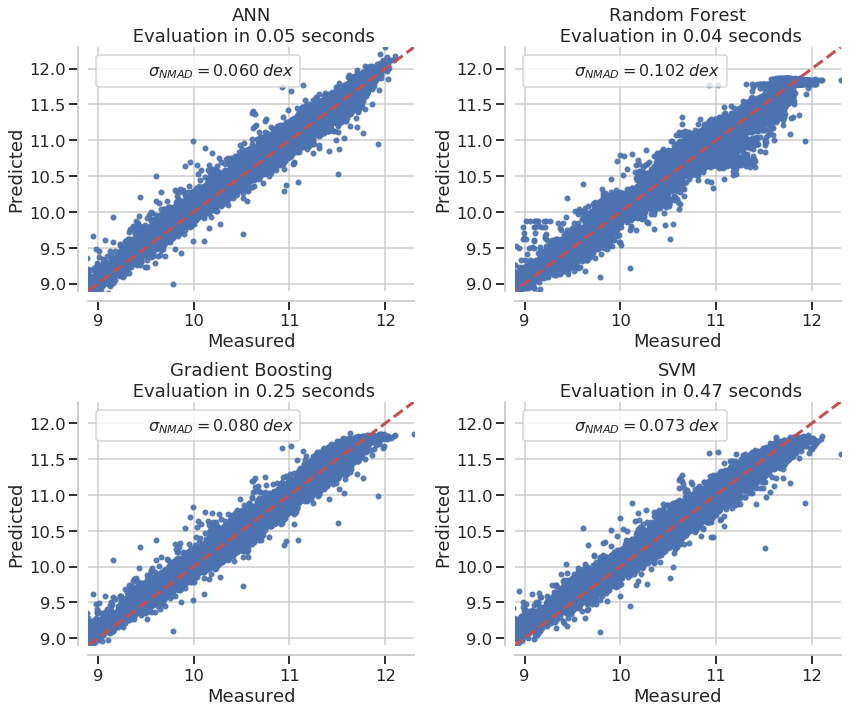

In [62]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = np.ravel(axs)

for ax, (name, est) in zip(axs, estimators):
    elapsed_time = est.elapsed_time
    y_target_pred = est.predict(x_target_2)
    snmad = median_abs_deviation(y_target-y_target_pred,scale=1/1.4826)
    offset = np.median(y_target-y_target_pred)
    plot_regression_results(
        ax, y_target, y_target_pred+offset,
        name, r'$\sigma_{NMAD} = %.3f \; dex$'%(snmad),
        elapsed_time)
    ax.set_xlim(8.9,)
    ax.set_ylim(8.9,)
# plt.suptitle('Single predictors versus stacked predictors')
plt.tight_layout()
# plt.subplots_adjust(top=0.9)
fig.savefig('compare_different_ml_predictors.png',dpi=100,facecolor='w',transparent=False)

Elapsed time to compute the importances: 0.140 seconds


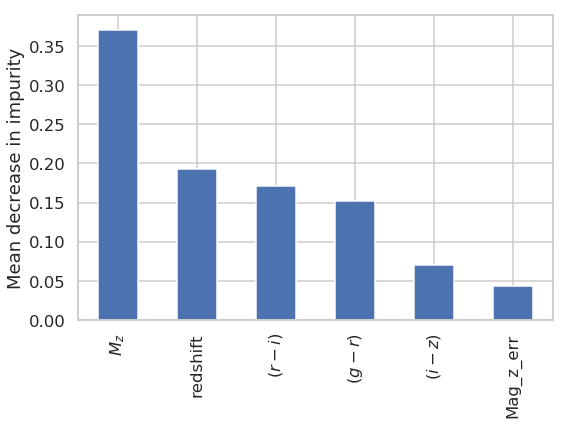

In [64]:
est = estimators[2][1].steps[0][1]
start_time = time.time()
importances = est.feature_importances_
std = np.std([est.feature_importances_ for tree in est.estimators_], axis=0)
elapsed_time = time.time() - start_time

print("Elapsed time to compute the importances: {elapsed_time:.3f} seconds".format(elapsed_time=elapsed_time))

feature_names = [r'$M_z$']
feature_names+= [r'$(%s - %s)$'%(bp0,bp1) for bp0, bp1 in zip(['g','r','i'],['r','i','z'])]
# feature_names+= ['Mag_%s'%bpF for bpF in ['z']]
feature_names+= ['Mag_%s_err'%bpF for bpF in ['z']]
# feature_names+= ['Err(%s - %s)'%(bp0,bp1) for bp0, bp1 in zip(['g','r','i'],['r','i','z'])]
feature_names+= ['redshift']


feature_names

ix = np.argsort(-1*importances)
forest_importances = pd.Series(importances[ix], index=np.array(feature_names)[ix])

fig, ax = plt.subplots(figsize=(8,6))
forest_importances.plot.bar(yerr=std[ix], ax=ax)
# ax.set_title("Cosmos with Mag-DM and RedSeq Offset")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
# fig.savefig('feature_importance_mag_dm_rs.png',dpi=100,transparent=False,facecolor='w')

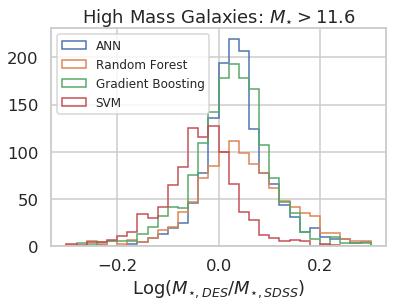

In [66]:
# xhigh = y_target>11.6
for name, est in estimators:
    ypred = est.predict(x_target_2)
    res = ypred-y_target
    yhigh = (ypred-np.median(res))>11.6
    plt.hist((res-np.median(res))[yhigh], bins=np.linspace(-0.3,0.3,31),histtype='step',label=name)
    plt.title('High Mass Galaxies: $M_{\star}>11.6$')
plt.xlabel('Log($M_{\star,DES}/M_{\star,SDSS}$)')
plt.legend(fontsize=12,loc=2)

Also the best for high mass galaxies